In [29]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

First we will drop the rows with nan values

In [4]:
data.dropna(inplace=True)
data = data[data['Income']<300000]
data.reset_index(inplace=True)

In [5]:
for col in data.columns:
  unique_values = data[col].unique()
  num_unique_values = len(unique_values)
  print(f"Column: {col}")
  print(f"Number of unique values: {num_unique_values}")
  print(f"Unique values: {unique_values}")
  print()

Column: index
Number of unique values: 2215
Unique values: [   0    1    2 ... 2237 2238 2239]

Column: ID
Number of unique values: 2215
Unique values: [5524 2174 4141 ... 7270 8235 9405]

Column: Year_Birth
Number of unique values: 59
Unique values: [1957 1954 1965 1984 1981 1967 1971 1985 1974 1950 1976 1959 1952 1987
 1946 1980 1949 1982 1979 1951 1969 1989 1963 1970 1973 1943 1975 1996
 1968 1964 1977 1978 1955 1966 1988 1948 1958 1972 1960 1983 1945 1991
 1962 1953 1956 1992 1961 1900 1986 1893 1990 1947 1899 1993 1994 1941
 1944 1995 1940]

Column: Education
Number of unique values: 5
Unique values: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']

Column: Marital_Status
Number of unique values: 8
Unique values: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']

Column: Income
Number of unique values: 1973
Unique values: [58138. 46344. 71613. ... 56981. 69245. 52869.]

Column: Kidhome
Number of unique values: 3
Unique values: [0 1 2]

Column: Teenhome
Num

Let's add an Age column instead of the year of birth.

However, some values in Year_Birth are accidentaly starting with 18.. instead of 19.. So we will fix this first.

In [6]:
for i in range(len(data)):
  if data.loc[i, 'Year_Birth'] <= 1900:
    data.loc[i, 'Year_Birth'] += 100

data['Age'] = 2021-data['Year_Birth']
data.drop('Year_Birth', axis=1, inplace=True)
data['Age'].unique()

array([64, 67, 56, 37, 40, 54, 50, 36, 47, 71, 45, 62, 69, 34, 75, 41, 72,
       39, 42, 70, 52, 32, 58, 51, 48, 78, 46, 25, 53, 57, 44, 43, 66, 55,
       33, 73, 63, 49, 61, 38, 76, 30, 59, 68, 65, 29, 60, 21, 35, 28, 31,
       74, 22, 27, 80, 77, 26, 81])

Next we will simplify the Education column and then one-hot encode it

In [7]:
education_mapping = {
    'PhD': 'Postgraduate',
    'Master': 'Postgraduate',
    '2n Cycle': 'Postgraduate',
    'Graduation': 'Graduate',
    'Basic': 'Undergraduate'
}

data['Education'] = data['Education'].replace(education_mapping)
data = pd.get_dummies(data, columns=['Education'])

Same for the maritial status column

In [8]:
maritial_mapping = {
    'Married': 1,
    'Together': 1,
    'Single': 0,
    'Divorced': 0,
    'Widow': 0,
    'Alone': 0,
    'Absurd': 0,
    'YOLO': 0
}

data['Marital_Status'] = data['Marital_Status'].replace(maritial_mapping)
data.rename(columns={'Marital_Status': 'Living_Status'}, inplace=True)

Next, we will convert the enrollment date to the number of months that the customer has been enrolled from

In [9]:
data['Enrolled_Months'] = (pd.to_datetime('01-12-2021', format="%d-%m-%Y") - pd.to_datetime(data['Dt_Customer'], format="%d-%m-%Y")).dt.days//30
data.drop('Dt_Customer', axis=1, inplace=True)


Next, we will add a total spending column and remove some irrelevant columns related to promotional campaigns.

In [10]:
data['Total_Spending'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

drop_columns = ['Z_CostContact', 'Z_Revenue', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'ID']
data.drop(drop_columns, axis=1, inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    2215 non-null   int64  
 1   Living_Status            2215 non-null   int64  
 2   Income                   2215 non-null   float64
 3   Kidhome                  2215 non-null   int64  
 4   Teenhome                 2215 non-null   int64  
 5   Recency                  2215 non-null   int64  
 6   MntWines                 2215 non-null   int64  
 7   MntFruits                2215 non-null   int64  
 8   MntMeatProducts          2215 non-null   int64  
 9   MntFishProducts          2215 non-null   int64  
 10  MntSweetProducts         2215 non-null   int64  
 11  MntGoldProds             2215 non-null   int64  
 12  NumDealsPurchases        2215 non-null   int64  
 13  NumWebPurchases          2215 non-null   int64  
 14  NumCatalogPurchases     

In [12]:
data.drop('index', axis=1, inplace=True)

Next, we will do some visualizations

In [13]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

<Axes: >

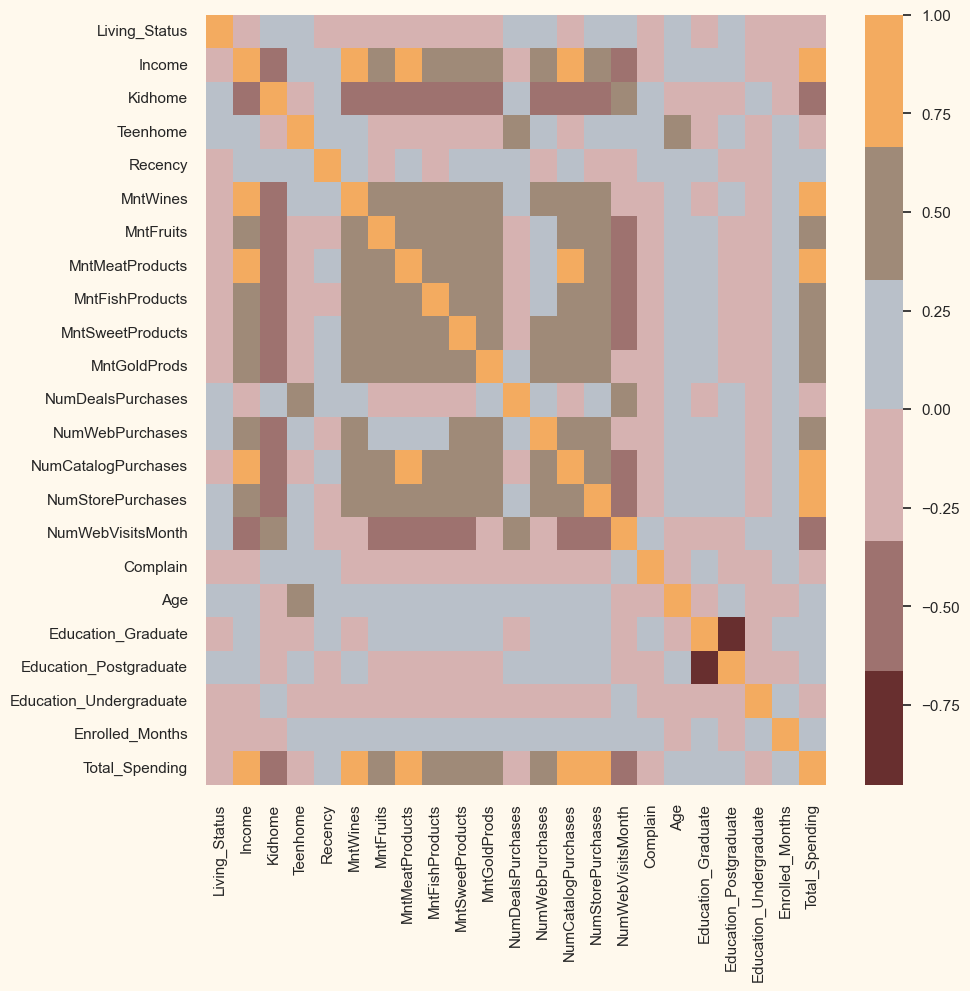

In [14]:
# Correlation matrix
corrmat= data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, cmap=cmap, center=0)

We will next create a copy of the dataframe for scaling

In [15]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = pd.DataFrame(scaler.transform(data),columns= data.columns )
scaled_data.head()

,Living_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Age,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Enrolled_Months,Total_Spending
0,-1.348357,0.286604,-0.822585,-0.929363,0.310113,0.977779,1.548973,1.689714,2.453932,1.484340,...,2.504074,-0.554500,0.693215,-0.097834,1.018226,0.993251,-0.945929,-0.158077,1.522853,1.675011
1,-1.348357,-0.261407,1.040427,0.908618,-0.380899,-0.872375,-0.637338,-0.718196,-0.651178,-0.634081,...,-0.571253,-1.169839,-0.131420,-0.097834,1.273801,0.993251,-0.945929,-0.158077,-1.139786,-0.962727
2,0.741643,0.912723,-0.822585,-0.929363,-0.795506,0.358096,0.568903,-0.178646,1.339745,-0.147087,...,-0.229550,1.291518,-0.543738,-0.097834,0.336691,0.993251,-0.945929,-0.158077,-0.252239,0.279830
3,0.741643,-1.176680,1.040427,-0.929363,-0.795506,-0.872375,-0.561948,-0.655768,-0.505056,-0.585381,...,-0.912956,-0.554500,0.280897,-0.097834,-1.281955,0.993251,-0.945929,-0.158077,-0.991861,-0.919594
4,0.741643,0.293806,1.040427,-0.929363,1.553934,-0.392047,0.418123,-0.218777,0.152497,-0.000989,...,0.112153,0.060839,-0.131420,-0.097834,-1.026379,-1.006795,1.057162,-0.158077,-0.991861,-0.307440


We will use PCA to reduce the dimension of the dataset

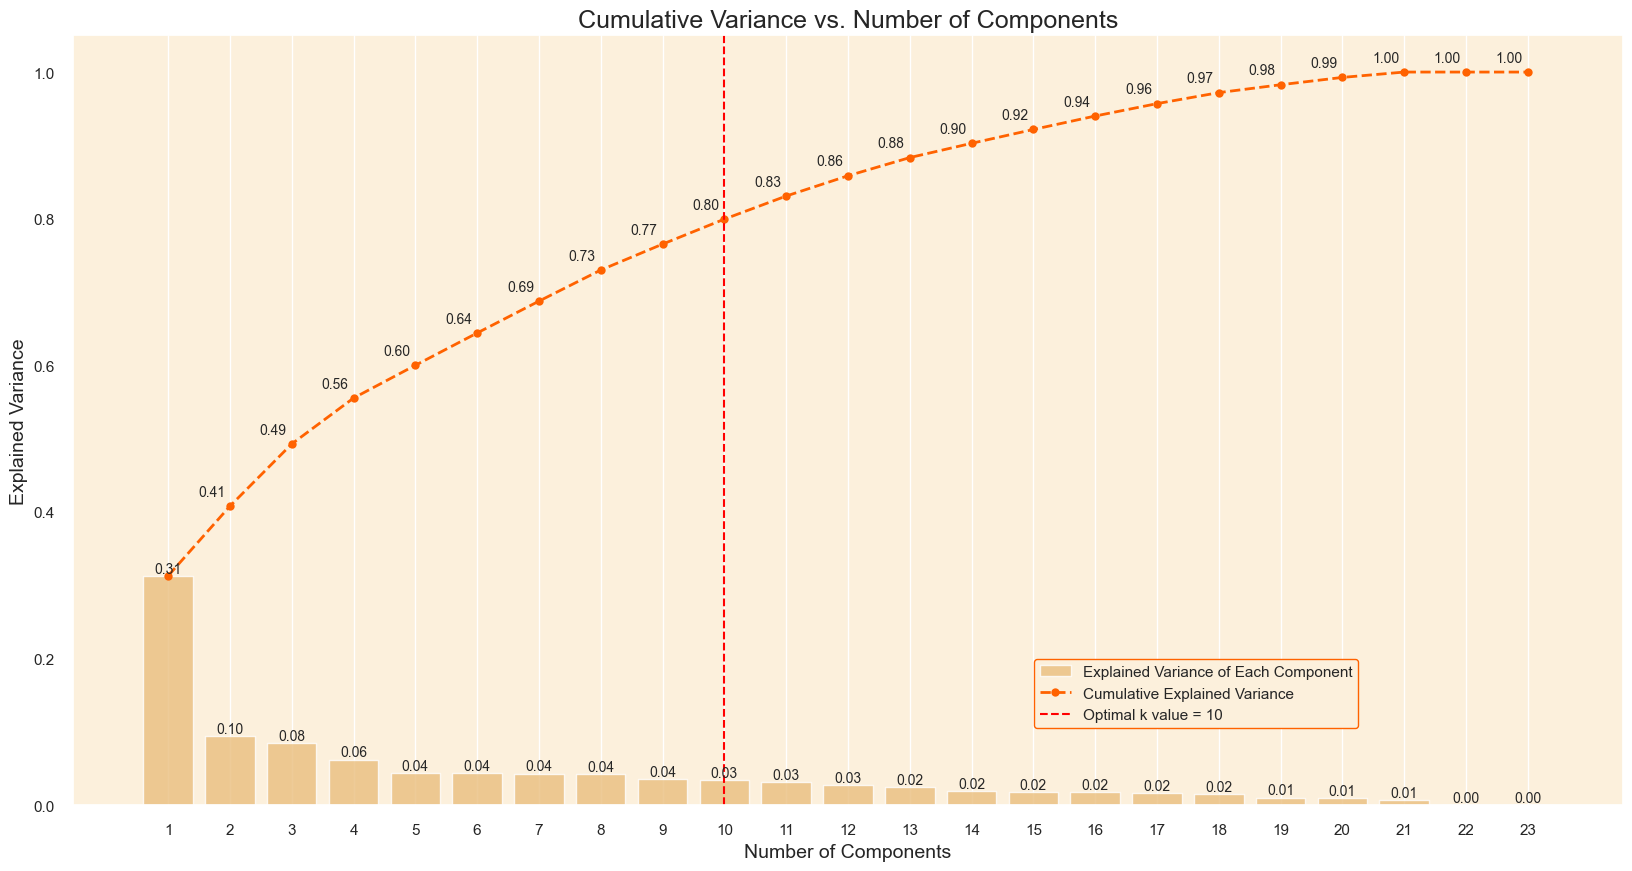

In [16]:
# Apply PCA
pca = PCA().fit(scaled_data)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 10

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [17]:
# Creating a PCA object with 10 components
pca = PCA(n_components=10)

# Fitting and transforming the original data to the new PCA dataframe
PCA_ds = pca.fit_transform(scaled_data)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
PCA_ds = pd.DataFrame(PCA_ds, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
PCA_ds.index = scaled_data.index

Next, we will use the elbow method and silhouette score to find the optimal number of clusters

Elbow Method to determine the number of clusters to be formed:


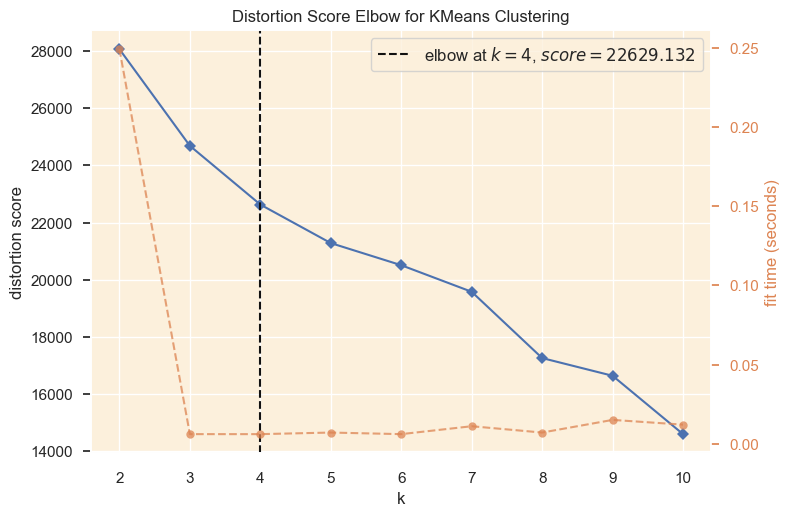

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [19]:
import matplotlib.gridspec as gridspec
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

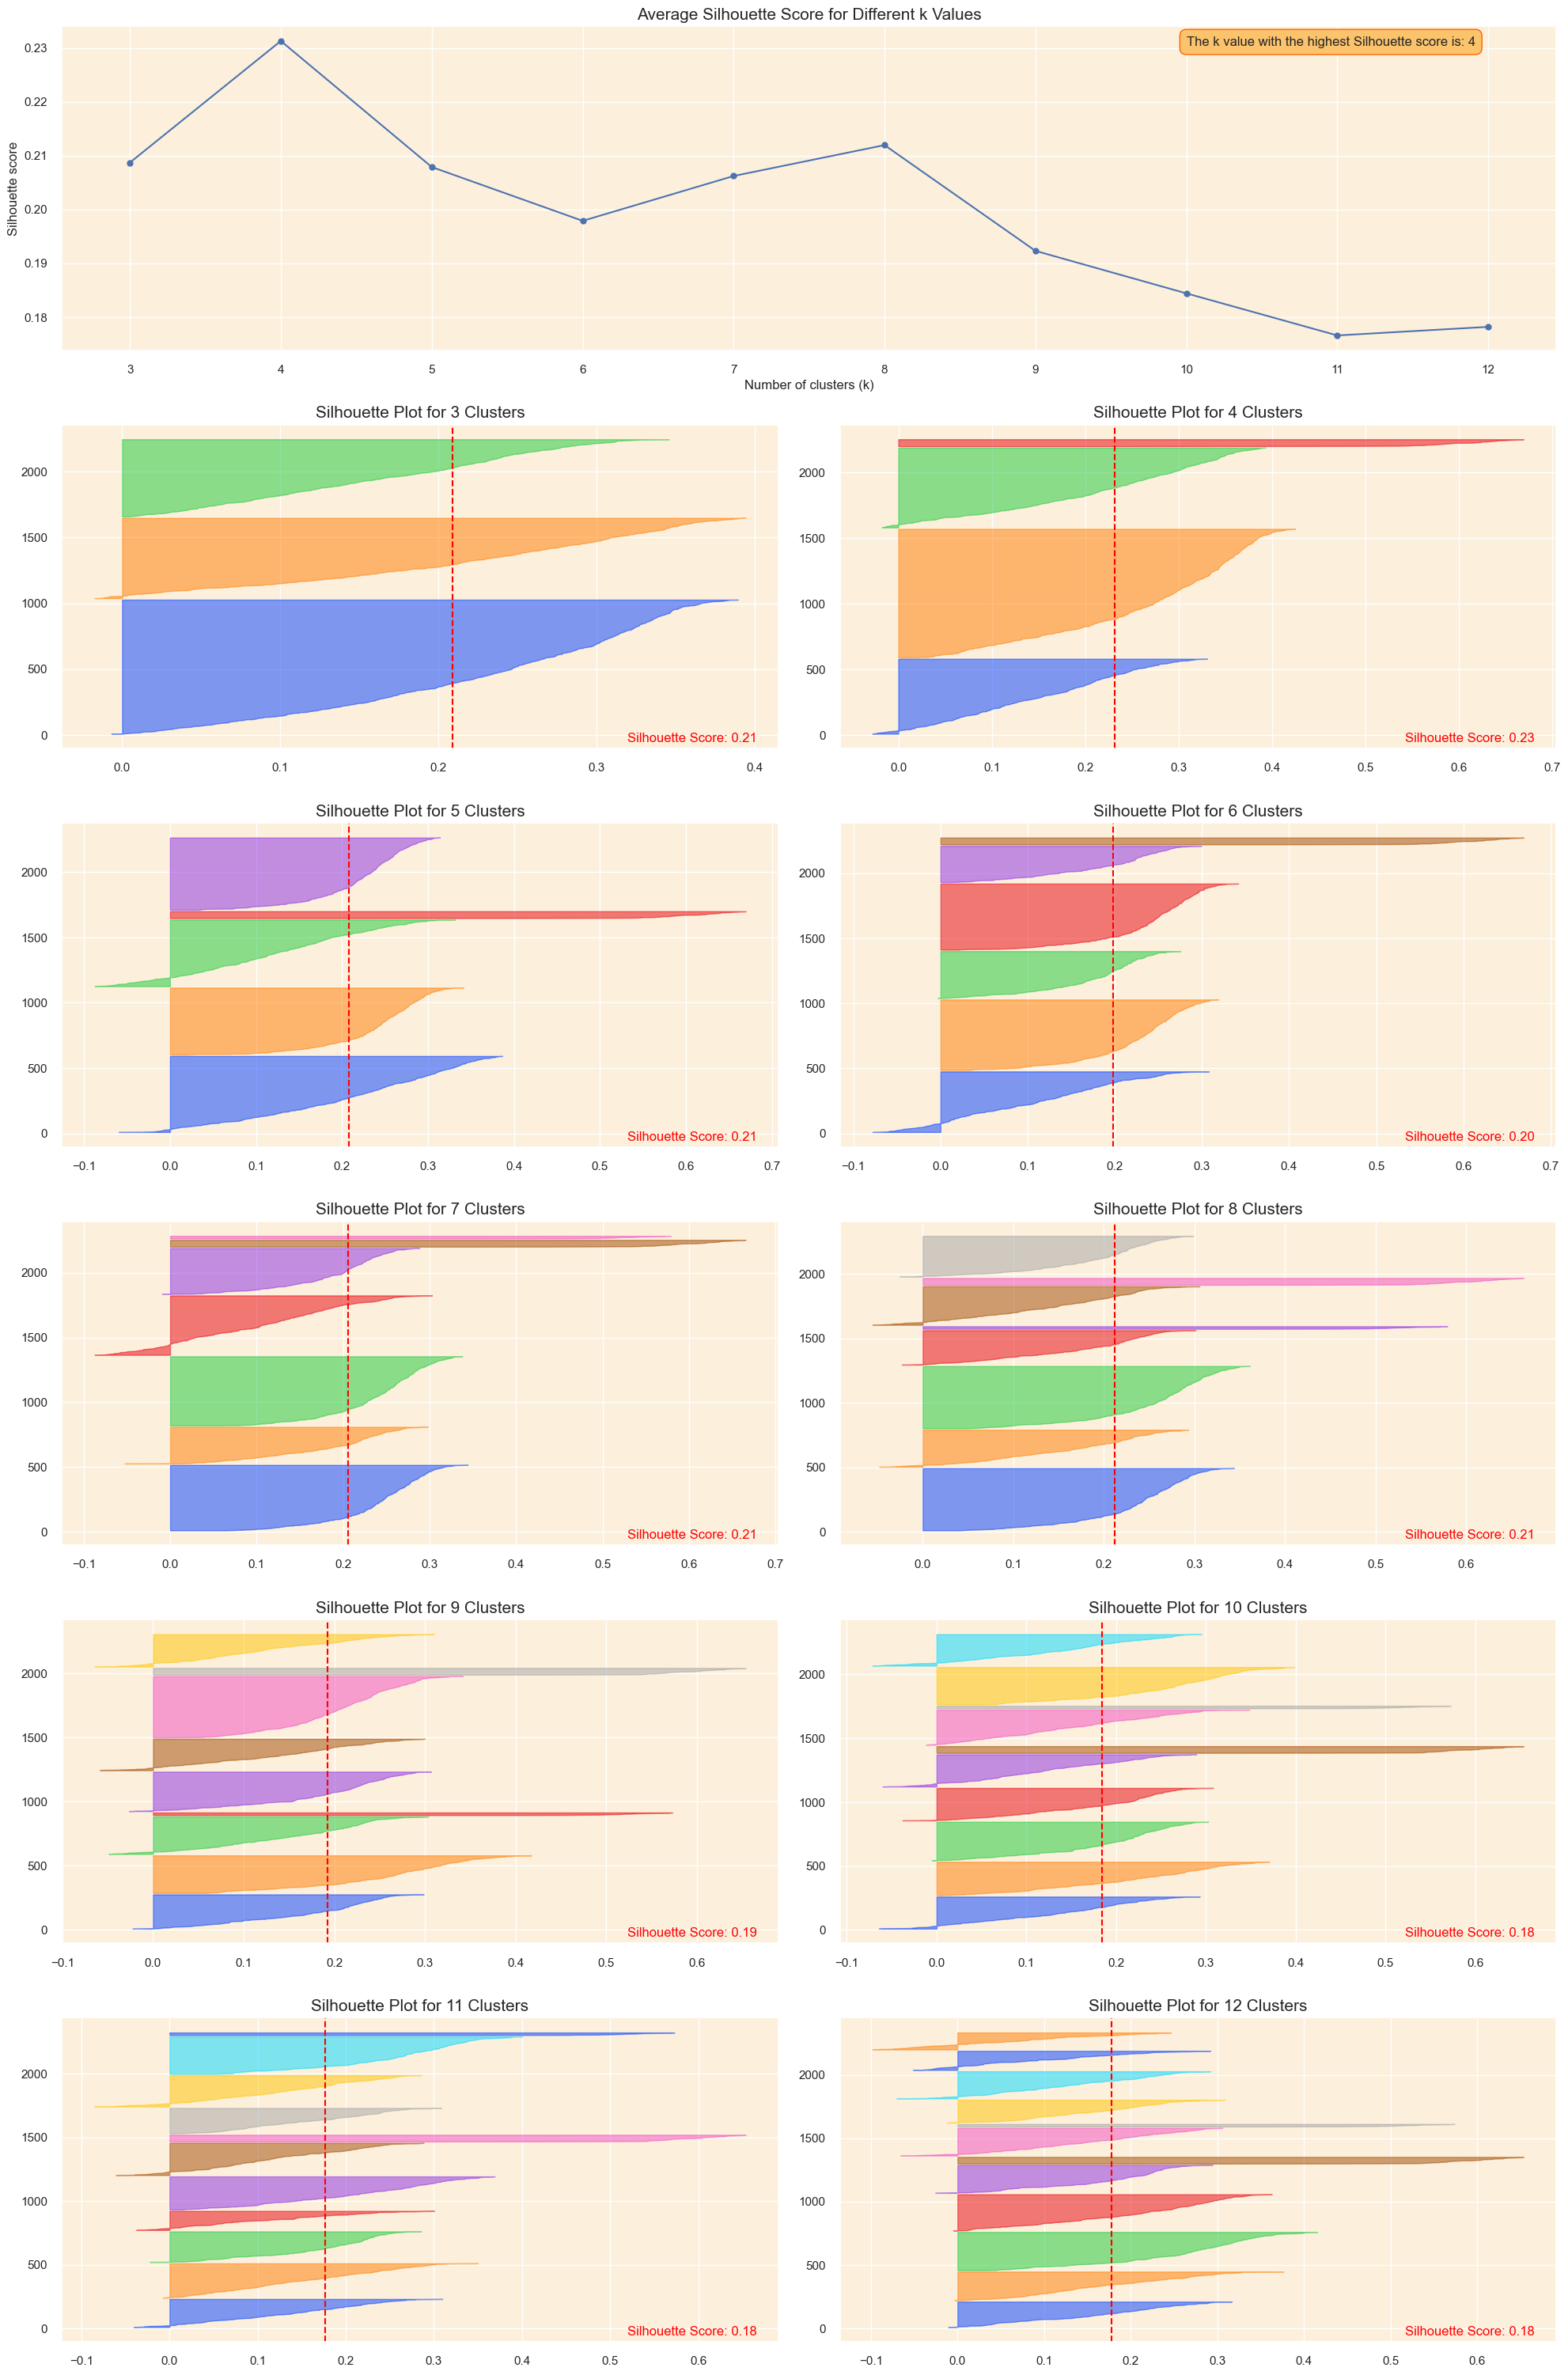

In [20]:
silhouette_analysis(PCA_ds, 3, 12, figsize=(20, 50))


The silhoutte plot for 4 clusters is quite imbalanced, so we will use 3 clusters for our data

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0)
PCA_ds["Clusters"] = kmeans.fit_predict(PCA_ds)

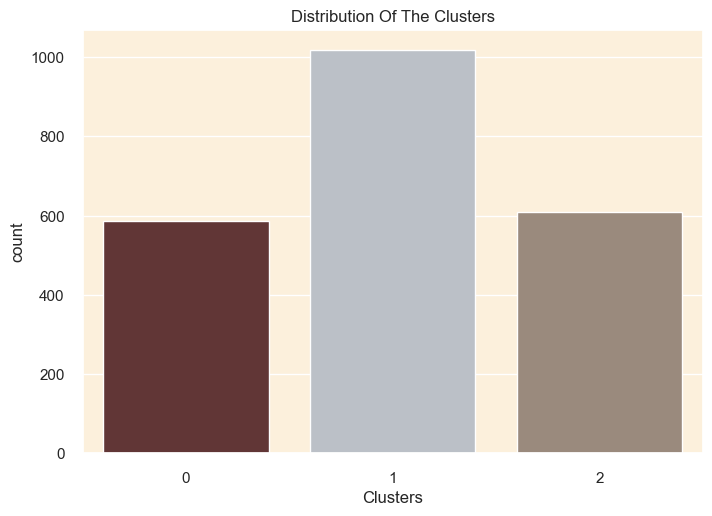

In [22]:
# Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=PCA_ds["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

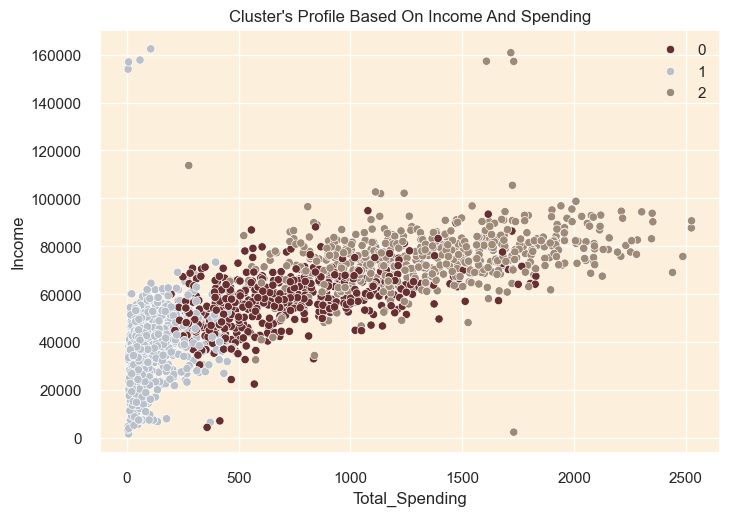

In [23]:
data["Clusters"] = PCA_ds["Clusters"]
pl = sns.scatterplot(data = data,x=data["Total_Spending"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

#Profiling

<Figure size 800x550 with 0 Axes>

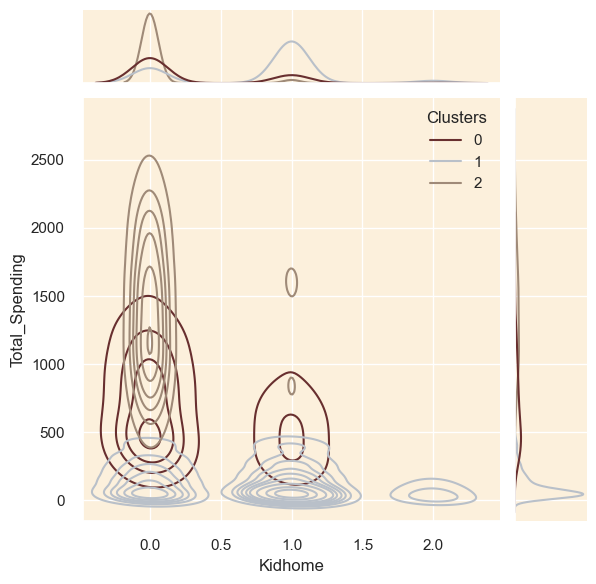

<Figure size 800x550 with 0 Axes>

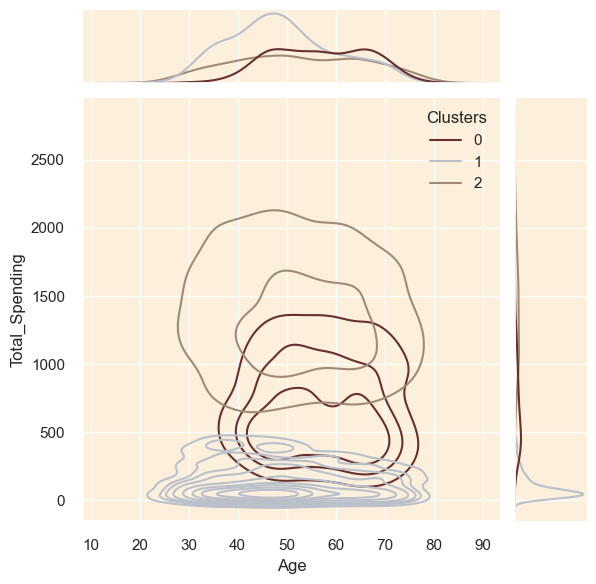

In [24]:
Personal = [ "Kidhome", "Age"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Total_Spending"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

#Radar Analysis

In [25]:
data.head()

,Living_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,Complain,Age,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Enrolled_Months,Total_Spending,Clusters
0,0,58138.0,0,0,58,635,88,546,172,88,...,4,7,0,64,True,False,False,112,1617,2
1,0,46344.0,1,1,38,11,1,6,2,1,...,2,5,0,67,True,False,False,94,27,1
2,1,71613.0,0,0,26,426,49,127,111,21,...,10,4,0,56,True,False,False,100,776,2
3,1,26646.0,1,0,26,11,4,20,10,3,...,4,6,0,37,True,False,False,95,53,1
4,1,58293.0,1,0,94,173,43,118,46,27,...,6,5,0,40,False,True,False,95,422,1


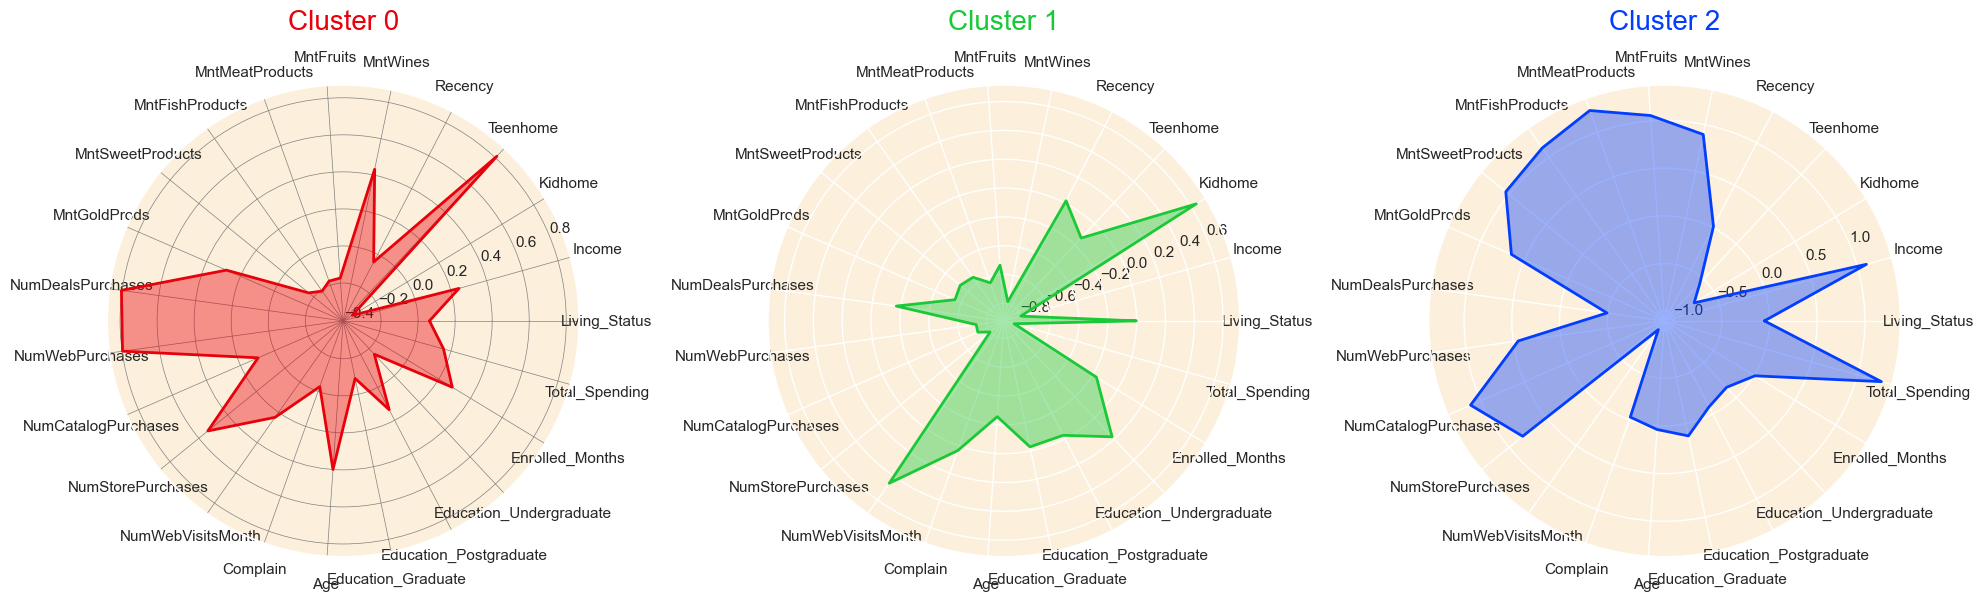

In [26]:
# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(data.drop(columns=['Clusters'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=data.columns[:-1])
df_customer_standardized['cluster'] = data['Clusters']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# Create radar chart for each cluster
for i, color in enumerate(colors):
    radar_data = cluster_centroids.loc[i].tolist()
    radar_data += radar_data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, radar_data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

We can clearly see through our analysis of the clusters that Cluster 1 are the low income families with lesser spendings, Cluster 0 has the medium income families which are likely to have children at home, and cluster 2 are the high spenders which don't have children at home.

#DBSCAN

Next, we will use a density based technique called DBSCAN to cluster our data

In [27]:
data_dbscan = data.drop(columns=['Clusters'])
data_dbscan.head()

,Living_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Age,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Enrolled_Months,Total_Spending
0,0,58138.0,0,0,58,635,88,546,172,88,...,10,4,7,0,64,True,False,False,112,1617
1,0,46344.0,1,1,38,11,1,6,2,1,...,1,2,5,0,67,True,False,False,94,27
2,1,71613.0,0,0,26,426,49,127,111,21,...,2,10,4,0,56,True,False,False,100,776
3,1,26646.0,1,0,26,11,4,20,10,3,...,0,4,6,0,37,True,False,False,95,53
4,1,58293.0,1,0,94,173,43,118,46,27,...,3,6,5,0,40,False,True,False,95,422


We will use grid search to get the values of epsilon and min_samples which have the best silhouette score

Best eps: 3.9000000000000004, Best min_samples: 7, Best silhouette score: 0.28226385111875285


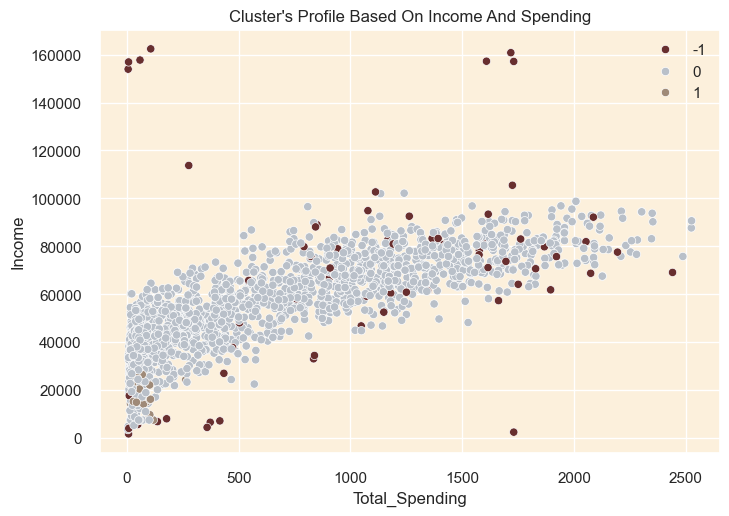

In [30]:
# Standardize the data
data_scaled = StandardScaler().fit_transform(data_dbscan)

# Function to perform DBSCAN with different parameters
def perform_dbscan(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data_scaled)
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    silhouette_avg = silhouette_score(data_scaled, clusters) if num_clusters > 1 else -1
    return clusters, num_clusters, silhouette_avg

# Try different values for eps and min_samples
best_eps = None
best_min_samples = None
best_silhouette = -1
best_clusters = None

for eps in np.arange(0.1,4.0,0.1):
    for min_samples in range(2, 20):
        clusters, num_clusters, silhouette_avg = perform_dbscan(eps, min_samples)
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_eps = eps
            best_min_samples = min_samples 
            best_clusters = clusters

print(f'Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_silhouette}')

# Add the best cluster labels to the dataset
data['Clusters'] = best_clusters

# Plot the results
pal = ["#682F2F", "#B9C0C9", "#9F8A78", "#F3AB60"]
pl = sns.scatterplot(data=data, x=data["Total_Spending"], y=data["Income"], hue=data["Clusters"], palette=pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [31]:
from collections import Counter

cluster_counts = Counter(clusters)
print(cluster_counts)


Counter({np.int64(0): 2049, np.int64(-1): 114, np.int64(1): 52})


We find that in this case, DBSCAN is not able to provide a good grouping of the data and groups most of the points under one group. This is probably because our data points are fairly evenly spaced and DBSCAN performs best when there is a clearer separation between different groups.